In [1]:
# To use TF 2.0 (on EC2 instance running Deep Learning AMI):
# source activate tensorflow_p36
# pip uninstall tensorflow-gpu
# pip install tensorflow-gpu==2.0.0-alpha0

# But then later decided wanted even newer GPU stuff and "in that conda env, ran:
# pip uninstall tensorflow-gpu
# pip install --upgrade pip
# pip install wrapt --ignore-installed # ran this because had an error
# pip install  tf-nightly-gpu-2.0-preview

# Result: Successfully installed tf-nightly-gpu-2.0-preview-2.0.0.dev20190606

In [2]:
import os
import pytz
import datetime as dt
import numpy as np
import tensorflow as tf

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams["axes.grid"] = False # don't show grid lines on plots by default
plt.rcParams['figure.figsize'] = (12, 16) # increase size of subplots

In [4]:
from packaging import version

print("TensorFlow version: ", tf.__version__) # make sure >= 2.0.0-dev20190606 (07 broken!)
assert version.parse(tf.__version__).release[0] >= 2, "This notebook requires TensorFlow 2.0 or above."


TensorFlow version:  2.0.0-dev20190608


In [5]:
import cs230_project_utilities as utils

In [6]:
# GPU usage logging (TF 2.0+)

tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(False)

In [7]:
def localized_timestamp():
    return dt.datetime.now(tz=pytz.timezone('America/Los_Angeles')).strftime("%Y-%m-%d_%H:%M:%S")

In [8]:
# Predict on a test batch

def predict_and_visualize(model, x, y):

    # Run model
    y_pred = model.predict(x)

    # Inspect output
    for i in range(len(x)):

        fft = utils.fastmri._combine_two_channels_of_complex_tensor(x[i]).numpy()
        fft_mag = np.abs(fft)
        fft_ang = np.angle(fft)
        reconstruction = y_pred[i, ..., 0]
        image = y[i, ..., 0]

        MSE = utils.signal_processing.mean_square_error(reconstruction, image)
        PSNR = utils.signal_processing.PSNR(reconstruction, image, max_value=max(image.max(), reconstruction.max()))

        plt.subplot(2, 2, 1)
        plt.title('Reconstruction (MSE: {:0.5f}, PSNR: {:0.5f})'.format(MSE, PSNR))
        utils.plot.imshowgray(reconstruction)

        plt.subplot(2, 2, 2)
        plt.title('FFT (Magnitude)')
        utils.plot.imshowfft(fft_mag)

        plt.subplot(2, 2, 3)
        plt.title('Expected reconstruction')
        utils.plot.imshowgray(image)

        plt.subplot(2, 2, 4)
        plt.title('FFT (Phase)')
        utils.plot.imshowgray(fft_ang)

        plt.show()
        break
        
    print('For validation: x.sum()={}, y.sum()={}, y_pred.sum()={}'.format(x.sum(), y.sum(), y_pred.sum()))
    print('Model iterations: {}'.format(model.optimizer.iterations.numpy()))
        
    # Return model output
    return y_pred

# Load a saved model

def restore_model(restore_path, weights_only, model=None, custom_objects=None):
    '''
    Restoring saved models
    
    - To restore a `tf.keras.Model` saved with `model.save_weights(...)`:
        Set `weights_only` to `True`. Restore weights at `restore_path` into `model`.
    - To restore a `tf.keras.Model` saved with `model.save(...)`:
        Set `weights_only` to `False`. Load and return and entire model at `restore_path`,
        optionally passing in the dictionary `custom_objects`.
    '''
    if weights_only:
        assert model is not None, 'Must pass a model if only restoring weights.'
        model.load_weights(restore_path)
    else:
        assert model is None, 'Do not pass a model if only restoring weights. A model will be returned.'
        model = tf.keras.models.load_model(restore_path, custom_objects=custom_objects)

    return model



# Load dataset as TFRecords 

In [9]:
# Sync from remote storage in s3
# aws s3 sync s3://cs230-automap/data/fastmri/tfrecords cs230/data/fastmri/tfrecords

In [10]:
dev_locations = '/home/ubuntu/cs230/data/fastmri/tfrecords/singlecoil_dev/*.tfrecord'
test_locations = '/home/ubuntu/cs230/data/fastmri/tfrecords/singlecoil_test/*.tfrecord'
train_locations = '/home/ubuntu/cs230/data/fastmri/tfrecords/singlecoil_train/*.tfrecord'

In [11]:
# Use tf.data.Datasets to preprocess and iterate data efficiently

batch_size = 32

dev_dataset = utils.fastmri.load_dataset(dev_locations,
                                         batch_size=8,
                                         shuffle_buffer_size=384,
                                         load_original_reconstruction=False,
                                         include_all_parsed_features=False,
                                         ignore_errors=True,
                                         data_augmentation='symmetric')

test_dataset = utils.fastmri.load_dataset(test_locations,
                                          batch_size=8,
                                          shuffle_buffer_size=384,
                                          load_original_reconstruction=False,
                                          include_all_parsed_features=False,
                                          ignore_errors=True,
                                          data_augmentation=None)

train_dataset = utils.fastmri.load_dataset(train_locations,
                                           batch_size=batch_size,
                                           shuffle_buffer_size=1024,
                                           load_original_reconstruction=False,
                                           include_all_parsed_features=False,
                                           ignore_errors=True,
                                           data_augmentation='symmetric')

Loading dataset... Shuffle items? True. Shuffle buffer: 384
Loading dataset... Shuffle items? True. Shuffle buffer: 384
Loading dataset... Shuffle items? True. Shuffle buffer: 1024


# Validate dataset
Make sure target reconstruction is the same as reconstruction computed from input.

In [12]:
# First batch of each dataset to be used in plotting images periodically to tensorboard

first_test_batch = next(iter(test_dataset))
first_dev_batch = next(iter(dev_dataset))
first_train_batch = next(iter(train_dataset))

In [13]:
def first_batches():
    batches = [(first_test_batch, 'Test'), (first_dev_batch, 'Dev'), (first_train_batch, 'Train')]
    return batches

In [14]:
first_test_batch[0].shape

TensorShape([8, 128, 128, 2])

In [15]:
fft, target_image = first_test_batch[0][-1].numpy().squeeze(), first_test_batch[1][-1].numpy().squeeze()
fft = utils.fastmri._combine_two_channels_of_complex_tensor(fft).numpy()

# Compute image from input `fft`
image_from_fft = tf.abs(utils.signal_processing.tf_ifft2d(fft)).numpy().squeeze()

# Compare target image to reconstruction from input `fft`
np.allclose(image_from_fft, target_image, atol=1e-6), utils.signal_processing.mean_square_error(image_from_fft, target_image)

(True, 6.5216912e-15)

In [16]:
# Should be in [0, 1]
image_from_fft.min(), image_from_fft.max(), target_image.min(), target_image.max()

(0.0024772414, 0.9999999, 0.0024772119, 0.99999994)

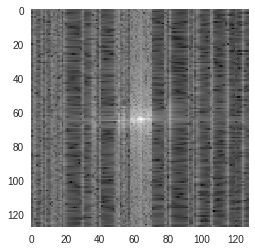

In [17]:
utils.plot.imshowfft(fft)

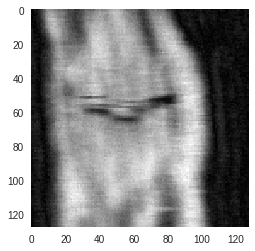

In [18]:
utils.plot.imshowgray(target_image)

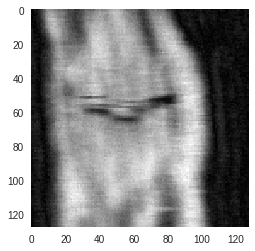

In [19]:
utils.plot.imshowgray(image_from_fft)

/home/ubuntu/cs230/code/MRI_reconstruction_example/cs230_project_utilities/plot.py:13: RuntimeWarning: divide by zero encountered in log10
  imshowgray(20 * np.log10(np.abs(fft)))


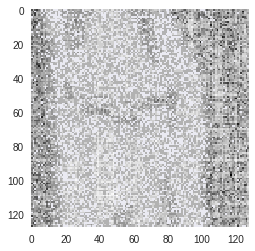

In [20]:
utils.plot.imshowfft(np.square(target_image - image_from_fft))

# Model

In [21]:
# A metric to use during training
def mean_PSNR(y_true, y_pred):
    max_value = 1.0
    MSE = tf.reduce_mean(tf.square(y_true - y_pred), axis=[1, 2, 3])
    PSNR = 10 * tf.math.log(tf.divide(max_value ** 2, MSE)) / tf.math.log(tf.constant(10, dtype=y_pred.dtype))
    mean = tf.reduce_mean(PSNR)
    return mean

In [22]:
# Model most similar to OG AUTOMAP
def load_uncompiled_automap_model():

    N = 128
    X = tf.keras.layers.Input(shape=(N, N, 2))

    # Paper says 1% multiplicative gaussian noise (this multiplies by 1-centered gaussian
    # having stddev = sqrt(rate / (1 - rate)) (here, 0.00032...)
    noisy_X = tf.keras.layers.GaussianDropout(rate=1e-7)(X) # spatial dimension: 256
    # Note: (we could corrupt when training with cifar, but maybe not other dataset?)

    ds_flat = tf.keras.layers.Flatten()(noisy_X)

    fc1 = tf.keras.layers.Dense(64 ** 2, activation='tanh')(ds_flat) # closer to original paper is: 128 ** 2
    fc2 = tf.keras.layers.Dense(128 ** 2, activation='tanh')(fc1)

    fc_output = tf.keras.layers.Reshape([128, 128, 1])(fc2)

    conv1 = tf.keras.layers.Conv2D(64, (5, 5), strides=(1, 1), activation='relu', padding='same')(fc_output)
    
    # L1 regularization to encourage sparsity
    conv2 = tf.keras.layers.Conv2D(64, (5, 5), strides=(1, 1), activation='relu', padding='same',
                                   activity_regularizer=tf.keras.regularizers.l1(1e-6))(conv1) # paper: 1e-4

    Y_pred = tf.keras.layers.Conv2DTranspose(1, (7, 7), strides=1, activation='relu', padding='same')(conv2) # upsample to spatial dimension 128

    model = tf.keras.Model(inputs=X, outputs=Y_pred)

    return model

In [23]:
def lr_schedule(epoch):
    initial_lr = 2e-4
    if epoch < 50:
        return 2e-4
    elif epoch >= 50 and epoch < 150:
        return 1e-4
    elif epoch >= 150 and epoch < 175:
        return 1e-5
    elif epoch >= 175 and epoch < 190:
        return 5e-5
    elif epoch >= 190 and epoch < 200:
        return 1e-5
    elif epoch >= 200 and epoch < 220:
        return 1e-6
    elif epoch >= 220 and epoch < 250:
        return 5e-6
    elif epoch >= 250 and epoch < 270:
        return 1e-6
    else:
        return 1e-7

In [24]:
def load_compiled_automap_model():
    multi_gpu = False
    if multi_gpu:
        # Distribute training across GPUs (each GPU receives identical updates to weights but different batches w/
        # mirrored strategy). Restricts callbacks we can use
        mirrored_strategy = tf.distribute.MirroredStrategy()
        with mirrored_strategy.scope():
            model = load_uncompiled_automap_model()
            optimizer = tf.keras.optimizers.Adam()
            model.compile(loss='mse', optimizer=optimizer, metrics=[mean_PSNR])
    else:
        model = load_uncompiled_automap_model()
        optimizer = tf.keras.optimizers.Adam()
        model.compile(loss='mse', optimizer=optimizer, metrics=[mean_PSNR])
    return model

In [25]:
# Uncomment to train a new model
model = load_compiled_automap_model()
initial_epoch = 0

In [26]:
def epoch_from_model_path(path):
    # Used to resume training.
    # Example:
    # Returns 150 if `path = '/home/ubuntu/cs230/models/automap_fastmri/2019-06-07_00:49:20/cp-0150.ckpt'.

    epoch_string = os.path.basename(path)[3:7]
    epoch = int(epoch_string)
    return epoch

In [27]:
# # Uncomment to restore a model and resume training
# saved_model_path = '/home/ubuntu/cs230/models/automap_fastmri/2019-06-07_00:49:20/cp-0165.ckpt'
# model = restore_model(saved_model_path, weights_only=False, custom_objects={'mean_PSNR': mean_PSNR})
# initial_epoch = epoch_from_model_path(saved_model_path)
# print('Restored model with {} completed epochs'.format(initial_epoch))
# model.evaluate(test_dataset)

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 2)]     0         
_________________________________________________________________
gaussian_dropout (GaussianDr (None, 128, 128, 2)       0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              134221824 
_________________________________________________________________
dense_1 (Dense)              (None, 16384)             67125248  
_________________________________________________________________
reshape (Reshape)            (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      1664  

# Training

In [29]:
# Show reconstructions during training

def plot_fft_reconstructions(epoch, logs):
    for dataset_batch, name in first_batches():
        x, y = dataset_batch
        y = y.numpy()
        y_pred = model.predict(x)

        with file_writer.as_default():
            for i in range(min(len(y), 10)):
                prediction, ground_truth = y_pred[i:i + 1, ...], y[i:i + 1, ...]
                tf.summary.image("{} Image {} (Prediction)".format(name, i), prediction, max_outputs=1, step=epoch)
                tf.summary.image("{} Image {} (Ground Truth)".format(name, i), ground_truth, max_outputs=1, step=epoch)

In [30]:
# Show activation histograms

def layer_activations(inputs):
    layers = model.layers
    names = [l.name for l in layers]
    input_tensor = layers[0].input
    outputs = [l.output for l in layers]
    
    get_activations = tf.keras.backend.function(input_tensor, outputs)
    activations = get_activations(inputs=inputs)
    
    return list(zip(names, activations))

def plot_activations(epoch, logs):
    with file_writer.as_default():
        for dataset_batch, stage in first_batches():
            for layer_name, layer_activation in layer_activations(dataset_batch):
                tf.summary.histogram('{}/activations/{}'.format(layer_name, stage.lower()), layer_activation,
                                    step=epoch)


In [31]:
# Clear logs and models if necessary
# !rm -r /home/ubuntu/cs230/logs/
# !rm -r /home/ubuntu/cs230/models

In [32]:
# Save current timestamp (we'll use it in our paths to model and log directories)

current_timestamp = localized_timestamp() # get new value if training new model
print('Using current timestamp: {}'.format(current_timestamp))

# current_timestamp = '2019-06-07_00:49:20' # use previous value if resuming training

Using current timestamp: 2019-06-08_13:06:26


In [33]:
# Define where logs will be saved

logdir = os.path.join('/home/ubuntu/cs230/logs', current_timestamp)
file_writer = tf.summary.create_file_writer(os.path.join(logdir, 'metrics'))

### Callbacks to use in various stages of training

In [34]:
# Callback for printing the LR at the end of each epoch.

class LearningRateLoggingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        with file_writer.as_default():
            current_lr = model.optimizer.lr.numpy()
            tf.summary.scalar('learning rate', data=current_lr, step=epoch)
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1, current_lr))

plot_images_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=plot_fft_reconstructions)

plot_activations_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=plot_activations)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, update_freq='epoch',
                                                      profile_batch=0) # workaround for: https://github.com/tensorflow/tensorboard/issues/2084

set_lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25,
                              patience=2, min_lr=1e-8)

# Callback for checkpointing model

# include the epoch in the file name. (uses `str.format`)
checkpoint_path = os.path.join('/home/ubuntu/cs230/models/automap_fastmri',
                               current_timestamp,
                               'cp-{epoch:04d}.ckpt')
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=False,
    # Save every K-batches (or samples?)
    save_freq=500_000)

completed_training_steps = model.optimizer.iterations.numpy()

if completed_training_steps == 0:
    # Only do this if not resuming training (don't want to overwrite anything, but also unnecessary
    # to prompt user by setting `overwrite=False`).
    model_save_path = checkpoint_path.format(epoch=0)
    model_save_dir = os.path.dirname(model_save_path)
    os.makedirs(model_save_dir, exist_ok=True)
    model.save(model_save_path)
elif completed_training_steps > 0:
    tensorboard_callback._samples_seen = completed_training_steps * batch_size
    tensorboard_callback._total_batches_seen = completed_training_steps

callbacks = [tensorboard_callback, plot_images_callback, plot_activations_callback,
             set_lr_callback, reduce_lr_callback, LearningRateLoggingCallback(), checkpoint_callback]

W0608 20:06:26.133667 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb940241f28> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 20:06:26.144600 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb940255620> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 20:06:26.158512 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 20:06:26.347359 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb9401092f0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 20:06:26.367959 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb92878f6a8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 20:06:26.420204 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

### Begin training and open Tensorboard to monitor

In [35]:
num_epochs = 300 # if resuming training, this still has to be higher than greatest checkpoint

training_history = model.fit(
    train_dataset,
    validation_data=dev_dataset,
    verbose=1, # set to 0 to suppress chatty output and use Tensorboard instead
    epochs=num_epochs,
    initial_epoch=initial_epoch,
    callbacks=callbacks,
    use_multiprocessing=True) # see if speeds things up

Epoch 1/300
   1085/Unknown - 113s 104ms/step - loss: 0.0080 - mean_PSNR: 22.8975
Learning rate for epoch 1 is 0.00019999999494757503
1085/1085 [==============================] - 138s 127ms/step - loss: 0.0080 - mean_PSNR: 22.8975 - val_loss: 0.0000e+00 - val_mean_PSNR: 0.0000e+00
Epoch 2/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0051 - mean_PSNR: 24.1620
Learning rate for epoch 2 is 0.00019999999494757503
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0051 - mean_PSNR: 24.1623 - val_loss: 0.0050 - val_mean_PSNR: 24.1815
Epoch 3/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0047 - mean_PSNR: 24.4665
Learning rate for epoch 3 is 0.00019999999494757503
1085/1085 [==============================] - 95s 87ms/step - loss: 0.0047 - mean_PSNR: 24.4668 - val_loss: 0.0048 - val_mean_PSNR: 24.3796
Epoch 4/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0044 - mean_PSNR: 24.7357
Learning rate for epoch 4 is 0.00

W0608 20:29:42.484948 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb94016f840> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 20:29:42.494563 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb9401d4f28> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 20:29:42.507483 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 20:29:42.694157 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb9401d41e0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 20:29:42.726780 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb940255620> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 20:29:42.736317 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 20:29:42.910696 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8ec6c3048> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 20:29:42.925852 140437208413952 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fb9401231e0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 20:29:42.942365 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8ec6c3488

1084/1085 [============================>.] - ETA: 0s - loss: 0.0032 - mean_PSNR: 26.1836
Learning rate for epoch 15 is 0.00019999999494757503
1085/1085 [==============================] - 98s 91ms/step - loss: 0.0032 - mean_PSNR: 26.1835 - val_loss: 0.0034 - val_mean_PSNR: 25.9432
Epoch 16/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0032 - mean_PSNR: 26.2374
Learning rate for epoch 16 is 0.00019999999494757503
1085/1085 [==============================] - 95s 87ms/step - loss: 0.0032 - mean_PSNR: 26.2374 - val_loss: 0.0033 - val_mean_PSNR: 26.0345
Epoch 17/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0031 - mean_PSNR: 26.3279
Learning rate for epoch 17 is 0.00019999999494757503
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0031 - mean_PSNR: 26.3280 - val_loss: 0.0033 - val_mean_PSNR: 26.1204
Epoch 18/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0031 - mean_PSNR: 26.4312
Learning rate for epoch 18 is

W0608 20:52:18.918913 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb9401d4d08> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 20:52:18.928411 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb94016fbf8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 20:52:18.941355 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 20:52:18.978641 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fba087a5d08> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 20:52:19.011200 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb940123158> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 20:52:19.022513 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 20:52:19.133080 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8ec6a5d90> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 20:52:19.154145 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8c40fb620> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 20:52:19.208225 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8c40ec378> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 20:52:19.224849 140437208413952 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fb94020b6a8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 20:52:19.242597 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8c40ec9d8

1084/1085 [============================>.] - ETA: 0s - loss: 0.0026 - mean_PSNR: 27.1388
Learning rate for epoch 29 is 0.00019999999494757503
1085/1085 [==============================] - 98s 91ms/step - loss: 0.0026 - mean_PSNR: 27.1388 - val_loss: 0.0028 - val_mean_PSNR: 26.8241
Epoch 30/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0026 - mean_PSNR: 27.1771
Learning rate for epoch 30 is 0.00019999999494757503
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0026 - mean_PSNR: 27.1772 - val_loss: 0.0028 - val_mean_PSNR: 26.8633
Epoch 31/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0026 - mean_PSNR: 27.2083
Learning rate for epoch 31 is 4.999999873689376e-05
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0026 - mean_PSNR: 27.2083 - val_loss: 0.0028 - val_mean_PSNR: 26.9341
Epoch 32/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0026 - mean_PSNR: 27.2788
Learning rate for epoch 32 is 

W0608 21:15:19.778940 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb940232950> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 21:15:19.788184 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb94016f9d8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 21:15:19.800785 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 21:15:19.838197 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb92878f7b8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 21:15:20.036039 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb9401d4ae8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 21:15:20.046612 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb9401d4f28> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 21:15:20.154485 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb940088840> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 21:15:20.175325 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 21:15:20.246608 140437208413952 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fb9401d4f28> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 21:15:20.264495 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a07d17b8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


1084/1085 [============================>.] - ETA: 0s - loss: 0.0023 - mean_PSNR: 27.7030
Learning rate for epoch 44 is 0.00019999999494757503
1085/1085 [==============================] - 98s 91ms/step - loss: 0.0023 - mean_PSNR: 27.7030 - val_loss: 0.0025 - val_mean_PSNR: 27.3664
Epoch 45/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0023 - mean_PSNR: 27.6942
Learning rate for epoch 45 is 4.999999873689376e-05
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0023 - mean_PSNR: 27.6941 - val_loss: 0.0025 - val_mean_PSNR: 27.3987
Epoch 46/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0023 - mean_PSNR: 27.7607
Learning rate for epoch 46 is 0.00019999999494757503
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0023 - mean_PSNR: 27.7605 - val_loss: 0.0025 - val_mean_PSNR: 27.4103
Epoch 47/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0023 - mean_PSNR: 27.7572
Learning rate for epoch 47 is 

W0608 21:37:57.343979 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb940054048> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 21:37:57.352942 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb94016f9d8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 21:37:57.365377 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 21:37:57.431498 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8c40fbd90> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 21:37:57.440640 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8ec2c28c8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 21:37:57.543465 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb928742488> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 21:37:57.563076 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8c452cbf8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 21:37:57.614432 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb940088840> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 21:37:57.629732 140437208413952 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fb92878f510> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 21:37:57.646043 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a1d56510

1084/1085 [============================>.] - ETA: 0s - loss: 0.0021 - mean_PSNR: 28.2408
Learning rate for epoch 58 is 9.999999747378752e-05
1085/1085 [==============================] - 99s 91ms/step - loss: 0.0021 - mean_PSNR: 28.2408 - val_loss: 0.0023 - val_mean_PSNR: 27.8811
Epoch 59/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0021 - mean_PSNR: 28.2457
Learning rate for epoch 59 is 2.499999936844688e-05
1085/1085 [==============================] - 95s 87ms/step - loss: 0.0021 - mean_PSNR: 28.2454 - val_loss: 0.0023 - val_mean_PSNR: 27.8916
Epoch 60/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0021 - mean_PSNR: 28.2589
Learning rate for epoch 60 is 9.999999747378752e-05
1085/1085 [==============================] - 95s 87ms/step - loss: 0.0021 - mean_PSNR: 28.2589 - val_loss: 0.0023 - val_mean_PSNR: 27.8917
Epoch 61/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0021 - mean_PSNR: 28.2714
Learning rate for epoch 61 is 2.

W0608 22:00:59.674691 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a06769d8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 22:00:59.683694 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a07d1d08> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 22:00:59.696320 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 22:00:59.733352 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb92878f2f0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 22:00:59.765728 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb9401d4ae8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 22:00:59.775173 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 22:00:59.885478 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb940109d08> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 22:00:59.906044 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a0c658c8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 22:00:59.959173 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb9401d4598> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 22:00:59.974916 140437208413952 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fb8ec2c26a8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 22:00:59.991914 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a0c33840

1084/1085 [============================>.] - ETA: 0s - loss: 0.0021 - mean_PSNR: 28.3319
Learning rate for epoch 73 is 2.499999936844688e-05
1085/1085 [==============================] - 99s 91ms/step - loss: 0.0021 - mean_PSNR: 28.3318 - val_loss: 0.0023 - val_mean_PSNR: 27.9536
Epoch 74/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0021 - mean_PSNR: 28.3480
Learning rate for epoch 74 is 9.999999747378752e-05
1085/1085 [==============================] - 99s 92ms/step - loss: 0.0021 - mean_PSNR: 28.3479 - val_loss: 0.0022 - val_mean_PSNR: 27.9690
Epoch 75/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0021 - mean_PSNR: 28.3496
Learning rate for epoch 75 is 2.499999936844688e-05
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0021 - mean_PSNR: 28.3494 - val_loss: 0.0022 - val_mean_PSNR: 27.9637
Epoch 76/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0021 - mean_PSNR: 28.3469
Learning rate for epoch 76 is 9.

W0608 22:23:43.036092 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a1d56840> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 22:23:43.045335 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8ec14c510> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 22:23:43.057944 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 22:23:43.095026 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8ec2c2950> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 22:23:43.128141 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb92878f7b8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 22:23:43.137822 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 22:23:43.243807 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8c40ec488> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 22:23:43.263995 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a0937840> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 22:23:43.317568 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb9402a16a8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 22:23:43.334855 140437208413952 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fb8ec2c2950> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 22:23:43.352172 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a1248c80

1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.3788
Learning rate for epoch 87 is 2.499999936844688e-05
1085/1085 [==============================] - 98s 91ms/step - loss: 0.0020 - mean_PSNR: 28.3788 - val_loss: 0.0022 - val_mean_PSNR: 28.0070
Epoch 88/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.3826
Learning rate for epoch 88 is 9.999999747378752e-05
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0020 - mean_PSNR: 28.3826 - val_loss: 0.0022 - val_mean_PSNR: 27.9928
Epoch 89/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.3829
Learning rate for epoch 89 is 2.499999936844688e-05
1085/1085 [==============================] - 99s 91ms/step - loss: 0.0020 - mean_PSNR: 28.3829 - val_loss: 0.0022 - val_mean_PSNR: 28.0022
Epoch 90/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.3866
Learning rate for epoch 90 is 9.

W0608 22:46:21.080998 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8ec506048> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 22:46:21.090582 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8c40ecd08> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 22:46:21.103137 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 22:46:21.139792 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a0c33378> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 22:46:21.172633 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb940255bf8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 22:46:21.183973 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 22:46:21.293437 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8ec47d2f0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 22:46:21.314903 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a0223048> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 22:46:21.369532 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a0223a60> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 22:46:21.384931 140437208413952 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fb8c40fbd08> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 22:46:21.402698 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a014a488

1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.3977
Learning rate for epoch 101 is 2.499999936844688e-05
1085/1085 [==============================] - 98s 91ms/step - loss: 0.0020 - mean_PSNR: 28.3974 - val_loss: 0.0022 - val_mean_PSNR: 28.0096
Epoch 102/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.4039
Learning rate for epoch 102 is 9.999999747378752e-05
1085/1085 [==============================] - 95s 87ms/step - loss: 0.0020 - mean_PSNR: 28.4037 - val_loss: 0.0022 - val_mean_PSNR: 28.0138
Epoch 103/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.4043
Learning rate for epoch 103 is 2.499999936844688e-05
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0020 - mean_PSNR: 28.4040 - val_loss: 0.0022 - val_mean_PSNR: 28.0192
Epoch 104/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.4011
Learning rate for epoch 10

W0608 23:09:20.910341 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8ec6c3598> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 23:09:20.919851 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a02e1c80> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 23:09:20.932421 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 23:09:20.969099 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a0b551e0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 23:09:21.002911 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb9404c3158> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 23:09:21.012504 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 23:09:21.326481 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8ec47dbf8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 23:09:21.347129 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8ec506f28> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 23:09:21.401727 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.4119
Learning rate for epoch 116 is 9.999999747378752e-05
1085/1085 [==============================] - 98s 90ms/step - loss: 0.0020 - mean_PSNR: 28.4120 - val_loss: 0.0022 - val_mean_PSNR: 28.0094
Epoch 117/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.4076
Learning rate for epoch 117 is 2.499999936844688e-05
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0020 - mean_PSNR: 28.4075 - val_loss: 0.0022 - val_mean_PSNR: 28.0371
Epoch 118/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.4165
Learning rate for epoch 118 is 9.999999747378752e-05
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0020 - mean_PSNR: 28.4165 - val_loss: 0.0022 - val_mean_PSNR: 28.0368
Epoch 119/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.4037
Learning rate for epoch 11

W0608 23:31:55.233058 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a1d56ae8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 23:31:55.242812 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb92878f6a8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 23:31:55.256268 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 23:31:55.295293 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a12489d8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 23:31:55.327293 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb94016fd90> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 23:31:55.338466 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 23:31:55.645982 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb9404c38c8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 23:31:55.666260 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a014ad90> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 23:31:55.717298 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.4281
Learning rate for epoch 130 is 9.999999747378752e-05
1085/1085 [==============================] - 100s 92ms/step - loss: 0.0020 - mean_PSNR: 28.4279 - val_loss: 0.0022 - val_mean_PSNR: 28.0070
Epoch 131/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.4126
Learning rate for epoch 131 is 2.499999936844688e-05
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0020 - mean_PSNR: 28.4125 - val_loss: 0.0022 - val_mean_PSNR: 28.0576
Epoch 132/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.4182
Learning rate for epoch 132 is 9.999999747378752e-05
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0020 - mean_PSNR: 28.4180 - val_loss: 0.0022 - val_mean_PSNR: 28.0220
Epoch 133/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.4279
Learning rate for epoch 1

W0608 23:54:56.943475 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8c452c8c8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 23:54:56.952302 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a0b552f0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 23:54:56.964609 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0608 23:54:57.031835 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a0c33ea0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 23:54:57.040926 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a1248950> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 23:54:57.144781 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8ec506048> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 23:54:57.164703 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8923408c8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 23:54:57.216615 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8ec6c3ea0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0608 23:54:57.231958 140437208413952 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fb8c40fb7b8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0608 23:54:57.460538 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb892b4fea0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.4274
Learning rate for epoch 145 is 2.499999936844688e-05
1085/1085 [==============================] - 98s 91ms/step - loss: 0.0020 - mean_PSNR: 28.4272 - val_loss: 0.0022 - val_mean_PSNR: 28.0227
Epoch 146/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.4350
Learning rate for epoch 146 is 9.999999747378752e-05
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0020 - mean_PSNR: 28.4350 - val_loss: 0.0022 - val_mean_PSNR: 28.0421
Epoch 147/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.4219
Learning rate for epoch 147 is 2.499999936844688e-05
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0020 - mean_PSNR: 28.4218 - val_loss: 0.0022 - val_mean_PSNR: 28.0338
Epoch 148/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.4310
Learning rate for epoch 14

W0609 00:17:32.766807 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb940232378> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 00:17:32.775636 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8ec506b70> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 00:17:32.787783 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0609 00:17:32.853599 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb892b22e18> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 00:17:32.865217 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8ec47dae8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0609 00:17:32.970224 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a0937400> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 00:17:32.990370 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8907ef6a8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0609 00:17:33.042029 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb892b4fd08> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 00:17:33.057694 140437208413952 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fb8a0223bf8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 00:17:33.075594 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb890764a60

1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.5554
Learning rate for epoch 159 is 2.499999936844688e-06
1085/1085 [==============================] - 98s 90ms/step - loss: 0.0020 - mean_PSNR: 28.5554 - val_loss: 0.0022 - val_mean_PSNR: 28.1326
Epoch 160/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.5590
Learning rate for epoch 160 is 9.999999747378752e-06
1085/1085 [==============================] - 95s 87ms/step - loss: 0.0020 - mean_PSNR: 28.5590 - val_loss: 0.0022 - val_mean_PSNR: 28.1498
Epoch 161/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.5607
Learning rate for epoch 161 is 2.499999936844688e-06
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0020 - mean_PSNR: 28.5606 - val_loss: 0.0022 - val_mean_PSNR: 28.1481
Epoch 162/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.5656
Learning rate for epoch 16

W0609 00:40:08.910166 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a1d56730> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 00:40:08.920968 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a0223ea0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 00:40:08.932791 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0609 00:40:08.997236 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8907ef510> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 00:40:09.006099 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb890764158> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0609 00:40:09.108989 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb892408048> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0609 00:40:09.128840 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb89068be18> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0609 00:40:09.179842 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb892b4f488> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 00:40:09.194934 140437208413952 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fb892add620> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 00:40:09.211075 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8907642f0

1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.5786
Learning rate for epoch 173 is 2.499999936844688e-06
1085/1085 [==============================] - 97s 90ms/step - loss: 0.0020 - mean_PSNR: 28.5784 - val_loss: 0.0022 - val_mean_PSNR: 28.1595
Epoch 174/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.5793
Learning rate for epoch 174 is 9.999999747378752e-06
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0020 - mean_PSNR: 28.5793 - val_loss: 0.0022 - val_mean_PSNR: 28.1602
Epoch 175/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.5796
Learning rate for epoch 175 is 2.499999936844688e-06
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0020 - mean_PSNR: 28.5796 - val_loss: 0.0022 - val_mean_PSNR: 28.1544
Epoch 176/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.5406
Learning rate for epoch 17

W0609 01:03:06.167888 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8ec6c3598> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 01:03:06.176707 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a1248158> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 01:03:06.188454 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0609 01:03:06.224018 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb892408378> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 01:03:06.254444 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a0223d90> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 01:03:06.263420 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0609 01:03:06.369177 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb94016f950> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 01:03:06.388497 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8902c5378> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0609 01:03:06.438938 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a02237b8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 01:03:06.453870 140437208413952 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fb892408378> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 01:03:06.470040 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb89010f8c8

1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.5495
Learning rate for epoch 188 is 4.999999873689376e-05
1085/1085 [==============================] - 98s 90ms/step - loss: 0.0020 - mean_PSNR: 28.5493 - val_loss: 0.0022 - val_mean_PSNR: 28.1192
Epoch 189/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.5492
Learning rate for epoch 189 is 1.249999968422344e-05
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0020 - mean_PSNR: 28.5493 - val_loss: 0.0022 - val_mean_PSNR: 28.1341
Epoch 190/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0020 - mean_PSNR: 28.5422
Learning rate for epoch 190 is 4.999999873689376e-05
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0020 - mean_PSNR: 28.5421 - val_loss: 0.0022 - val_mean_PSNR: 28.1358
Epoch 191/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.5712
Learning rate for epoch 19

W0609 01:25:37.437966 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a02e1f28> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 01:25:37.447310 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8923090d0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 01:25:37.460309 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0609 01:25:37.498926 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb892b229d8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 01:25:37.533111 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb94016f840> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 01:25:37.543216 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0609 01:25:37.653425 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb892340268> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 01:25:37.674514 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8ec2c20d0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0609 01:25:37.728831 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb89010f2f0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 01:25:37.745186 140437208413952 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fb890528158> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 01:25:37.763269 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a0122840

1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.5945
Learning rate for epoch 202 is 9.999999974752427e-07
1085/1085 [==============================] - 98s 90ms/step - loss: 0.0019 - mean_PSNR: 28.5946 - val_loss: 0.0021 - val_mean_PSNR: 28.1798
Epoch 203/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.5964
Learning rate for epoch 203 is 2.499999993688107e-07
1085/1085 [==============================] - 95s 87ms/step - loss: 0.0019 - mean_PSNR: 28.5963 - val_loss: 0.0022 - val_mean_PSNR: 28.1672
Epoch 204/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.5940
Learning rate for epoch 204 is 9.999999974752427e-07
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0019 - mean_PSNR: 28.5940 - val_loss: 0.0021 - val_mean_PSNR: 28.1805
Epoch 205/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.5953
Learning rate for epoch 20

W0609 01:48:34.069704 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a0223840> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 01:48:34.079470 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb892b22f28> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 01:48:34.092370 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0609 01:48:34.286147 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb890764d90> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 01:48:34.308216 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8902c5488> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 01:48:34.365067 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.5923
Learning rate for epoch 217 is 2.499999993688107e-07
1085/1085 [==============================] - 99s 91ms/step - loss: 0.0019 - mean_PSNR: 28.5924 - val_loss: 0.0021 - val_mean_PSNR: 28.1835
Epoch 218/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.5886
Learning rate for epoch 218 is 9.999999974752427e-07
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0019 - mean_PSNR: 28.5885 - val_loss: 0.0021 - val_mean_PSNR: 28.1877
Epoch 219/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.5978
Learning rate for epoch 219 is 2.499999993688107e-07
1085/1085 [==============================] - 95s 87ms/step - loss: 0.0019 - mean_PSNR: 28.5977 - val_loss: 0.0021 - val_mean_PSNR: 28.1824
Epoch 220/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.5960
Learning rate for epoch 22

W0609 02:11:09.587758 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8ec47de18> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 02:11:09.596890 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8ec2c20d0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 02:11:09.610096 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0609 02:11:09.647851 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8907ef048> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 02:11:09.681152 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a0122488> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 02:11:09.690607 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0609 02:11:09.798794 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a1c29400> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 02:11:09.818514 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8909e3158> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0609 02:11:09.871136 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8907efd08> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 02:11:09.886826 140437208413952 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fb8ec2c20d0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 02:11:09.904494 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb890998620

1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.5943
Learning rate for epoch 231 is 1.249999968422344e-06
1085/1085 [==============================] - 98s 91ms/step - loss: 0.0019 - mean_PSNR: 28.5943 - val_loss: 0.0021 - val_mean_PSNR: 28.1695
Epoch 232/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.5985
Learning rate for epoch 232 is 4.999999873689376e-06
1085/1085 [==============================] - 95s 87ms/step - loss: 0.0019 - mean_PSNR: 28.5986 - val_loss: 0.0021 - val_mean_PSNR: 28.1730
Epoch 233/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.5976
Learning rate for epoch 233 is 1.249999968422344e-06
1085/1085 [==============================] - 95s 87ms/step - loss: 0.0019 - mean_PSNR: 28.5976 - val_loss: 0.0021 - val_mean_PSNR: 28.1883
Epoch 234/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.6000
Learning rate for epoch 23

W0609 02:33:44.904908 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8ec6a5378> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 02:33:44.913895 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb890ece840> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 02:33:44.926339 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0609 02:33:44.962397 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb890764ae8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 02:33:44.994438 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8902c5f28> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 02:33:45.003814 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0609 02:33:45.111674 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a01226a8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 02:33:45.131726 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb89081e598> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0609 02:33:45.184474 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb940054378> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 02:33:45.199698 140437208413952 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fb890764ae8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 02:33:45.216564 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8910f16a8

1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.5983
Learning rate for epoch 245 is 1.249999968422344e-06
1085/1085 [==============================] - 99s 92ms/step - loss: 0.0019 - mean_PSNR: 28.5982 - val_loss: 0.0021 - val_mean_PSNR: 28.1770
Epoch 246/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.6021
Learning rate for epoch 246 is 4.999999873689376e-06
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0019 - mean_PSNR: 28.6021 - val_loss: 0.0021 - val_mean_PSNR: 28.1772
Epoch 247/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.6029
Learning rate for epoch 247 is 1.249999968422344e-06
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0019 - mean_PSNR: 28.6027 - val_loss: 0.0021 - val_mean_PSNR: 28.1854
Epoch 248/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.5983
Learning rate for epoch 24

W0609 02:56:45.975093 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8902c5730> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 02:56:45.984807 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a1d56730> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 02:56:45.997502 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0609 02:56:46.064622 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb89243ad08> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 02:56:46.074178 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb891129ea0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0609 02:56:46.179136 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb890ece8c8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 02:56:46.199088 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb89081e730> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0609 02:56:46.251137 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb892addc80> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 02:56:46.267769 140437208413952 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fb89010fea0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 02:56:46.284876 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8910f1510

1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.5987
Learning rate for epoch 260 is 9.999999974752427e-07
1085/1085 [==============================] - 98s 90ms/step - loss: 0.0019 - mean_PSNR: 28.5986 - val_loss: 0.0021 - val_mean_PSNR: 28.1938
Epoch 261/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.6026
Learning rate for epoch 261 is 2.499999993688107e-07
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0019 - mean_PSNR: 28.6026 - val_loss: 0.0021 - val_mean_PSNR: 28.1903
Epoch 262/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.6037
Learning rate for epoch 262 is 9.999999974752427e-07
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0019 - mean_PSNR: 28.6036 - val_loss: 0.0021 - val_mean_PSNR: 28.1879
Epoch 263/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.6058
Learning rate for epoch 26

W0609 03:19:18.945319 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb892408e18> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 03:19:18.954919 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb890e21d90> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 03:19:18.968265 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0609 03:19:19.006883 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb892addf28> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 03:19:19.039150 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb892309950> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 03:19:19.050203 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0609 03:19:19.159350 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8910f1400> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 03:19:19.179589 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb874d6a048> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0609 03:19:19.233997 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb890ece8c8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 03:19:19.249925 140437208413952 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fb891129ea0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 03:19:19.268058 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb4a607d510

1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.6053
Learning rate for epoch 274 is 1.0000000116860974e-07
1085/1085 [==============================] - 98s 90ms/step - loss: 0.0019 - mean_PSNR: 28.6053 - val_loss: 0.0021 - val_mean_PSNR: 28.1861
Epoch 275/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.6062
Learning rate for epoch 275 is 2.5000000292152436e-08
1085/1085 [==============================] - 95s 87ms/step - loss: 0.0019 - mean_PSNR: 28.6063 - val_loss: 0.0021 - val_mean_PSNR: 28.1935
Epoch 276/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.6074
Learning rate for epoch 276 is 1.0000000116860974e-07
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0019 - mean_PSNR: 28.6073 - val_loss: 0.0021 - val_mean_PSNR: 28.1821
Epoch 277/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.6093
Learning rate for epoch

W0609 03:42:18.420143 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a07d1510> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 03:42:18.430111 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb890764158> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 03:42:18.445394 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0609 03:42:18.480465 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb890998d08> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 03:42:18.512997 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb874eac9d8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 03:42:18.522765 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0609 03:42:18.628947 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb892309488> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 03:42:18.650167 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb48c7726a8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


W0609 03:42:18.703519 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8a15afbf8> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 03:42:18.719674 140437208413952 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fb890998d08> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 03:42:18.736577 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb4a607dd08

1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.6073
Learning rate for epoch 289 is 2.5000000292152436e-08
1085/1085 [==============================] - 98s 91ms/step - loss: 0.0019 - mean_PSNR: 28.6073 - val_loss: 0.0021 - val_mean_PSNR: 28.1849
Epoch 290/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.5997
Learning rate for epoch 290 is 1.0000000116860974e-07
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0019 - mean_PSNR: 28.5995 - val_loss: 0.0021 - val_mean_PSNR: 28.2019
Epoch 291/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.6025
Learning rate for epoch 291 is 2.5000000292152436e-08
1085/1085 [==============================] - 94s 87ms/step - loss: 0.0019 - mean_PSNR: 28.6025 - val_loss: 0.0021 - val_mean_PSNR: 28.1804
Epoch 292/300
1084/1085 [============================>.] - ETA: 0s - loss: 0.0019 - mean_PSNR: 28.6005
Learning rate for epoch

### Save model (in case isn't saved after final epoch)

In [36]:
# Uncomment to save model
model_save_path = checkpoint_path.format(epoch=num_epochs)
model.save(model_save_path)
print('Saved model to: {}'.format(model_save_path))

W0609 04:01:15.993845 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8910f12f0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 04:01:16.003307 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb892408598> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 04:01:16.016225 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0609 04:01:16.415010 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb940232620> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 04:01:16.425731 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb890e21ea0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 04:01:16.534542 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_var

W0609 04:01:16.627792 140437208413952 ag_logging.py:145] Entity <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fb890e211e0> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'
W0609 04:01:16.646794 140437208413952 ag_logging.py:145] Entity <function Function._initialize_uninitialized_variables.<locals>.initialize_variables at 0x7fb8909e3158> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: No module named 'tensorflow_core.contrib'


Saved model to: /home/ubuntu/cs230/models/automap_fastmri/2019-06-08_13:06:26/cp-0300.ckpt


## Evaluate model

In [37]:
model.evaluate(test_dataset, verbose=1)
# model.evaluate(dev_dataset, verbose=1)
# model.evaluate(train_dataset, verbose=1)

    487/Unknown - 3s 7ms/step - loss: 0.0103 - mean_PSNR: 21.9150- 3s 7ms/step - loss: 0.0101 - mean_PSNR: 22. - 3s 7ms/step - loss: 0 - 3 - 3s 7ms/step - loss: 0.0103 - mean_PSNR - 3s 7ms/st - 3s 7ms/step - loss: 0.0103 - mean_PSNR: 21.9

[0.010305045667875106, 21.91499]

### Plot training history (but better viewed in Tensorboard)

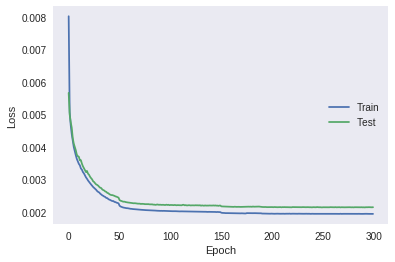

In [38]:
plt.figure()
plt.plot(training_history.history["loss"], label="Train")
plt.plot(training_history.history["val_loss"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="center right")

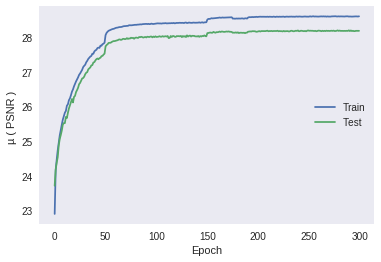

In [39]:
plt.figure()
plt.plot(training_history.history["mean_PSNR"], label="Train")
plt.plot(training_history.history["val_mean_PSNR"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("µ ( PSNR ) ")
plt.legend(loc="center right")

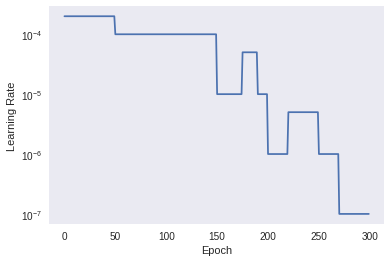

In [40]:
plt.figure()
plt.plot(training_history.history["lr"])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.yscale('log')

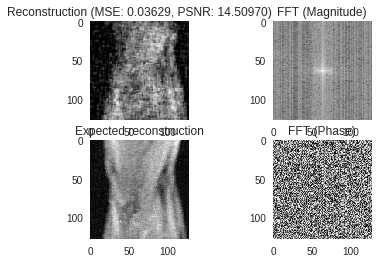

For validation: x.sum()=279.34979248046875, y.sum()=39581.15625, y_pred.sum()=34196.24609375
Model iterations: 325500


In [41]:
# Predict on a test batch

x, y = first_test_batch
x, y = x.numpy(), y.numpy()
predict_and_visualize(model, x, y);

# Restore and run saved model

In [42]:
saved_model_path = '/home/ubuntu/cs230/models/automap_fastmri/2019-06-07_00:49:20/cp-0150.ckpt'
restored_model = restore_model(saved_model_path, weights_only=False, custom_objects={'mean_PSNR': mean_PSNR})
predict_and_visualize(restored_model, x, y);

E0609 04:01:25.500474 140437208413952 ultratb.py:147] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-42-6bb18f391d48>", line 2, in <module>
    restored_model = restore_model(saved_model_path, weights_only=False, custom_objects={'mean_PSNR': mean_PSNR})
  File "<ipython-input-8-5546dfbd0612>", line 62, in restore_model
    model = tf.keras.models.load_model(restore_path, custom_objects=custom_objects)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/keras/saving/save.py", line 140, in load_model
    loader_impl.parse_saved_model(filepath)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/saved_model/loader_impl.py", line 83, in parse_saved_model
    constants.SAVED_MODEL_FILENAME_PB))
OSError: SavedModel file does not exist at: /home/ubu

OSError: SavedModel file does not exist at: /home/ubuntu/cs230/models/automap_fastmri/2019-06-07_00:49:20/cp-0150.ckpt/{saved_model.pbtxt|saved_model.pb}

In [ ]:
restored_model.evaluate(test_dataset, verbose=1)